# Single-currency model
Let's use an RNN to predict the future time evolution of exchange rates using a single currency.

# Data cleaning and preprocessing

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

The `filename` variable indicates the input currency. There are several different currency files you can choose from.

In [2]:
# Data input and preprocessing

# Choice of input files:
# DEXCAUS.csv  DEXJPUS.csv  DEXMXUS.csv  DEXUSUK.csv DEXCHUS.csv  DEXKOUS.csv  DEXUSEU.csv  DTWEXM.csv

# Reads in currency exchange rate data
filename='DEXUSEU' # Filename
dataset = pd.read_csv('data/'+filename+'.csv') # Reads in CSV file
exchangevalues = dataset.iloc[:, 1:2] # Selects columns

# Replaces missing data (represented by '.') with zeros ('0')
mask=exchangevalues=='.'
exchangevalues[mask] = '0'

# Reformats columns into floats
exchangevalues=np.array(exchangevalues)
exchangevalues=np.matrix([float(x) for x in exchangevalues])
exchangevalues=exchangevalues.transpose()

# Fills in missing and outlier values by taking average between adjacent timesteps
mean,std=np.mean(exchangevalues),np.std(exchangevalues) # Computes mean and std
indices = [i for i ,x in enumerate(exchangevalues) if x<mean-2.5*std] # Finds indices of zero and outlier values
for i in indices:
    # First, checks the initial and final elements of the list
    # If any of these are zero, set them to be equal to their adjacent values
    if i==0:
        exchangevalues[i] = exchangevalues[i+1]
    elif i==len(exchangevalues)-1:
        exchangevalues[i] = exchangevalues[i-1]
    
    # For the rest of the elements, set them to be the average of their adjacent values
    exchangevalues[i] = 0.5*(exchangevalues[i+1]+exchangevalues[i-1]) 
    
# Initializes the training set
training_set = exchangevalues
N_total_timesteps = len(training_set) # The total number of timesteps in the dataset

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Train/test set parameters
N_timesteps = 60 # Number of timesteps in each training epoch
N_test_timesteps = int(0.15*len(training_set_scaled)) # Number of timesteps for the test set

# Creating a data structure with N timesteps and 1 output
X_train = []
y_train = []
for i in range(N_timesteps, len(training_set)-N_test_timesteps):
    X_train.append(training_set_scaled[i-N_timesteps:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test = []
y_test = []
for i in range(len(training_set)-N_test_timesteps, len(training_set)):
    X_test.append(training_set_scaled[i-N_timesteps:i, 0])
    y_test.append(training_set_scaled[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print('training_set shape',training_set.shape)
print('X_train shape',X_train.shape)
print('y_train shape',y_train.shape)
print('X_test shape',X_test.shape)
print('y_test shape',y_test.shape)

training_set shape (2610, 1)
X_train shape (2159, 60, 1)
y_train shape (2159, 1)
X_test shape (391, 60, 1)
y_test shape (391, 1)


# Building the RNN

**Parameter tuning the RNN**

- Increase the number of timesteps. Note that this also tends to increase the phase delay of the prediction.
- Adding more LSTM layers
- Adding more neurons to the LSTM layers
- For parameter tuning, use scoring = 'neg_mean_squared_error'

In [20]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')


Here's a cool function I found that allows you to live plot the training losses as it happens in real time. This is useful for early stopping and preventing the model from overfitting!

In [21]:
# RNN architecture details
regressor.summary()

# A class for live plotting the losses as the RNN is trained
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, np.log10(self.losses),'k-', label="loss")
        plt.plot(self.x, np.log10(self.val_losses), 'g-', label="val_loss")
        plt.legend()
        plt.ylabel('log(Loss)')
        plt.xlabel('Epoch')
        plt.grid(True)

        plt.show();
        
plot_losses = PlotLosses()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 60, 50)            10400     
_________________________________________________________________
dropout_13 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_15 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 50)                20200     
__________

# Training the RNN

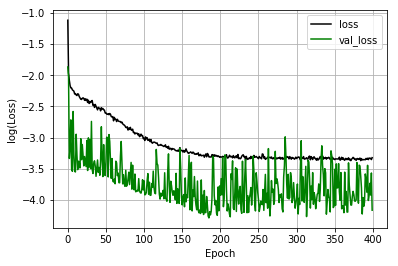

In [22]:
# Fit the RNN to the Training set
history=regressor.fit(X_train, y_train, validation_split=0.2, epochs = 400, \
                      batch_size = 32, callbacks=[plot_losses])

# Predictions and plots

In [23]:
# Makes preductions using the test set and the trained RNN model
predicted_values = regressor.predict(X_test)

# Inverts feature scaling transformation
y_train = sc.inverse_transform(y_train)
y_test = sc.inverse_transform(y_test)
predicted_values = sc.inverse_transform(predicted_values)

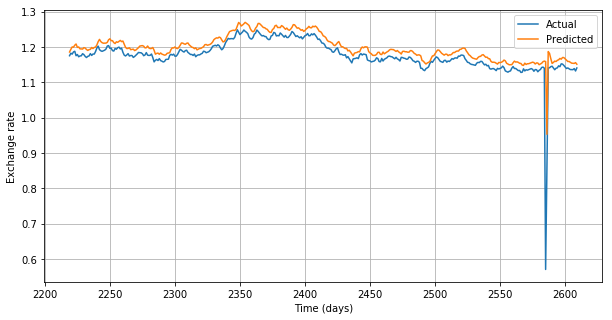

In [24]:
# Does plotting
plt.figure(figsize=(10,5))

#plt.plot(range(N_timesteps, len(training_set)-N_test_timesteps),y_train,label = 'Training data')
x_predicted=np.array(range(len(training_set)-N_test_timesteps, len(training_set)))
plt.plot(x_predicted,y_test,label = 'Actual')
plt.plot(x_predicted,predicted_values+0.02,label = 'Predicted')
#plt.plot(range(len(training_set)-N_test_timesteps, len(training_set)),predicted_values-y_test)


plt.xlabel('Time (days)')
plt.ylabel('Exchange rate')
#plt.ylim(1.2,1.4)
plt.legend()
plt.grid(True)

Result looks pretty good! It's interesting how the model even managed to predict the crash near the end of the test set. Even though the predicted depth of the crash was too small, it's still good enough to warn you that something drastic is going to happen.

From the loss plot, we can see that we could have trained the model with even more epochs, but seeing that the predictions are already very good that's probably not likely to give us any more useful information.

In [8]:
# Saves the trained RNN model
regressor.save('models/'+filename+'.h5')
print('Model saved')

Model saved
